# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 46071/46071 [03:00<00:00, 255.74it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

In [25]:
len(preprocessed_reviews)

46071

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [38]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [39]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [40]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [41]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8501250147819519), ('good', 0.8091933727264404), ('fantastic', 0.804183840751648), ('terrific', 0.7793824076652527), ('amazing', 0.7774198055267334), ('wonderful', 0.768098771572113), ('excellent', 0.7644588947296143), ('perfect', 0.7320027351379395), ('decent', 0.706425130367279), ('fabulous', 0.6786690354347229)]
[('greatest', 0.7595480680465698), ('best', 0.7222287654876709), ('tastiest', 0.6804364919662476), ('nastiest', 0.6793605089187622), ('awful', 0.6669774055480957), ('horrible', 0.6662197709083557), ('experienced', 0.6592317819595337), ('closest', 0.6400747895240784), ('hottest', 0.6185269951820374), ('disgusting', 0.6159205436706543)]


In [43]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 46071/46071 [04:45<00:00, 161.44it/s]


46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 46071/46071 [51:34<00:00, 14.89it/s]


In [26]:
final['CleanedText']=preprocessed_reviews

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


In [28]:
#Create Train/Test Split of data (based on time, as we have sorted data already)

Train_data=final.iloc[0:35000]
print("Train data dim :",Train_data.shape)

Test_data=final.iloc[35000:]
print("Test data dim :",Test_data.shape)

Train data dim : (35000, 11)
Test data dim : (11071, 11)


In [29]:
## Our target variable i.e. review polarity with values 'positive'and 'negative'
Y_train_Polarity=Train_data['Score'].values

In [30]:
from sklearn.calibration import CalibratedClassifierCV

In [31]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [33]:
# Create BOW with Train data
count_vect=CountVectorizer(dtype='float')
vocab=count_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
Train_counts=count_vect.transform(Train_data['CleanedText'].values)
Train_counts.get_shape()

(35000, 34486)

In [34]:
# Fit our BOW vectorizer on test data
Test_counts=count_vect.transform(Test_data['CleanedText'].values)
Test_counts.get_shape()

(11071, 34486)

###### Find optimal value of alpha using CV

In [56]:
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10]
alpha

array([1.0000000e-03, 1.0010000e+00, 2.0010000e+00, ..., 9.9997001e+04,
       9.9998001e+04, 9.9999001e+04])

In [63]:
cv_scores=[]
for a in alpha:
    BOW_SVM_linear=SGDClassifier(loss='hinge', penalty='l2', alpha=a)
    scores = cross_val_score(BOW_SVM_linear, Train_counts, Y_train_Polarity, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())

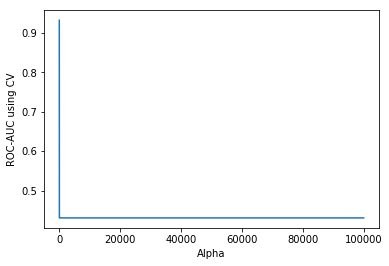

max value of roc_auc : 0.9316392231378086
Optimal value of alpha:  0.001


In [69]:
plt.plot(alpha, cv_scores)
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC using CV')
plt.show()
print('max value of roc_auc :',np.max(np.array(cv_scores)))
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('Optimal value of alpha: ',optimal_alpha)

In [80]:
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [83]:
## Let's using l1 penalty now and check the roc_auc for optimal alpha
cv_scores_l1=[]
for a in alpha:
    BOW_SVM_linear=SGDClassifier(loss='hinge', penalty='l1', alpha=a)
    scores = cross_val_score(BOW_SVM_linear, Train_counts, Y_train_Polarity, cv=10, scoring='roc_auc')
    cv_scores_l1.append(scores.mean())

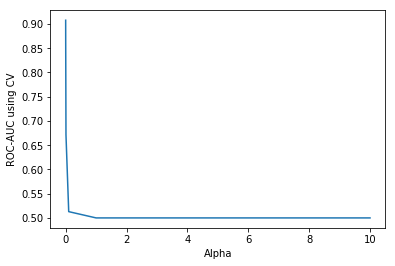

max value of roc_auc : 0.9076751621835895
Optimal value of alpha:  1e-05


In [84]:
plt.plot(alpha, cv_scores_l1)
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC using CV')
plt.show()
print('max value of roc_auc :',np.max(np.array(cv_scores_l1)))
optimal_alpha = alpha[cv_scores_l1.index(max(cv_scores_l1))]
print('Optimal value of alpha: ',optimal_alpha)

Thus , we see that we get better roc_auc with L2 penalty.

###### Check test data

In [95]:
BOW_SVM_linear=SGDClassifier(loss='hinge', penalty='l1', alpha=0.00001)
BOW_SVM_linear.fit(Train_counts,Y_train_Polarity)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [96]:
test_predict=BOW_SVM_linear.predict(Test_counts)

In [97]:
test_predict[0:10]

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int64)

In [98]:
Test_data['Score'].head()

7865    0
7864    0
7863    1
7862    1
7861    0
Name: Score, dtype: int64

In [99]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [100]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.8404544008607743


We checked both L1 nad L2 penalty on test data. With L2 we got roc_auc of 0.80 while with L1 we get ruc_auc of 0.84.

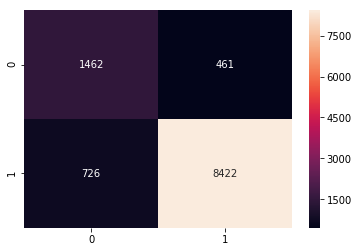

In [108]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [110]:
fpr,tpr,_=roc_curve(actual_test,predicted_test)

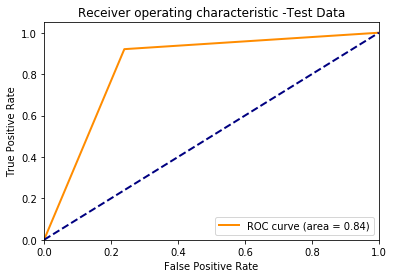

In [113]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

######  AUC after Calibration

In [94]:
## use calibrated cv with isotonic calibration
clf=SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(Train_counts, Y_train_Polarity)
prob_pos_isotonic = clf_isotonic.predict_proba(Test_counts)[:, 1]

In [182]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [190]:
auc(fpr,tpr)

0.9372432155703367

In [191]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.9372432155703367


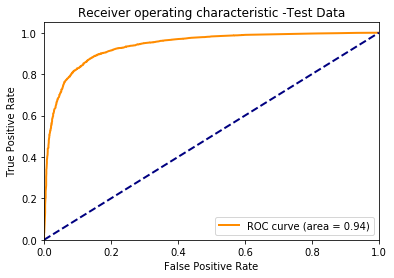

In [192]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

###### Feature Importance- for positive and negative reviews

In [103]:
from wordcloud import WordCloud

In [101]:
Coef=BOW_SVM_linear.coef_

In [102]:
neg_class=sorted(zip(Coef[0],count_vect.get_feature_names()),reverse=False)[:50]
pos_class=sorted(zip(Coef[0],count_vect.get_feature_names()),reverse=True)[:50]
print('Most Negative Words')
print(neg_class)
print('------------------------')
print('Most Positive Words')
print(pos_class)

Most Negative Words
[(-213.78987570757064, 'worst'), (-170.4172583969388, 'disappointing'), (-131.09913594074516, 'disgusting'), (-104.62278762352248, 'yuck'), (-104.52630590773832, 'disappointment'), (-102.96726590892598, 'awful'), (-96.74565747859636, 'died'), (-95.65091540257544, 'threw'), (-94.81656889200956, 'shame'), (-93.5506981787879, 'horrible'), (-93.2236213242847, 'hopes'), (-88.19052213042367, 'mahi'), (-86.29888380231722, 'serious'), (-85.36468486595882, 'sencha'), (-82.92314945938415, 'chunk'), (-82.82253538459217, 'blah'), (-79.71614257975051, 'grounds'), (-78.43482471324242, 'bland'), (-78.18592546280628, 'terrible'), (-77.42044419668991, 'unpleasant'), (-77.21827258726539, 'dangerous'), (-76.90334136753344, 'vomiting'), (-76.26194626942052, 'trash'), (-74.80285410573187, 'poor'), (-74.64496203950175, 'return'), (-74.18145899093275, 'sharp'), (-72.90926770710186, 'diarrhea'), (-70.99804714569589, 'rip'), (-70.85557892892959, 'cancelled'), (-70.1416719536181, 'loss'), (-

###### Imp Positive Words

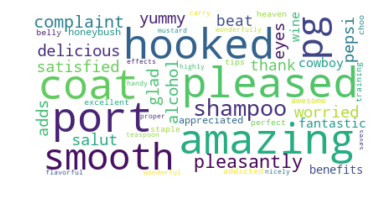

In [104]:
# Create and generate a word cloud image:
pos_weights,pos_words = zip(*pos_class)
text_pos = " ".join(word for word in pos_words)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)

# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Imp Negative Words

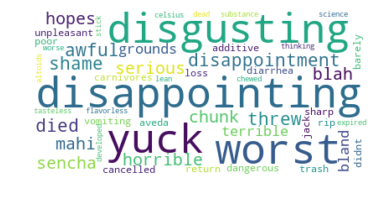

In [105]:
# Create and generate a word cloud image:
neg_weights,neg_words = zip(*neg_class)
text_neg = " ".join(word for word in neg_words)

wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)

# Display the generated image:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [114]:
## Create a tf-idf vectorizer-unigram

## For Train data

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1),dtype='float')
tf_idf_vocab=tf_idf_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
tf_idf_train_counts=tf_idf_vect.transform(Train_data['CleanedText'].values)
tf_idf_train_counts.get_shape()

(35000, 34486)

In [115]:
## For Test data
tf_idf_test_counts=tf_idf_vect.transform(Test_data['CleanedText'].values)
tf_idf_test_counts.get_shape()

(11071, 34486)

###### Finding Optimal alpha

In [116]:
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [117]:
## Use L2 penalty
cv_scores_l2=[]
for a in alpha:
    tfidf_SVM_linear=SGDClassifier(loss='hinge', penalty='l2', alpha=a)
    scores = cross_val_score(tfidf_SVM_linear, tf_idf_train_counts, Y_train_Polarity, cv=10, scoring='roc_auc')
    cv_scores_l2.append(scores.mean())

In [37]:
def plot_metric(alpha,cv_scores):
    plt.plot(alpha, cv_scores)
    plt.xlabel('Alpha')
    plt.ylabel('ROC-AUC using CV')
    plt.show()
    print('max value of roc_auc :',np.max(np.array(cv_scores)))
    optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
    print('Optimal value of alpha: ',optimal_alpha)

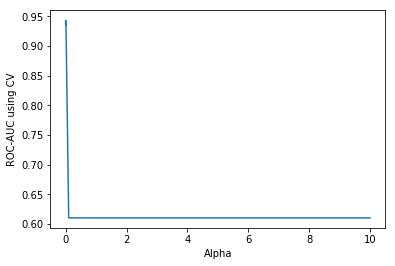

max value of roc_auc : 0.9435916215750477
Optimal value of alpha:  0.0001


In [119]:
plot_metric(alpha,cv_scores_l2)

In [121]:
## Use L1 penalty
cv_scores_l1=[]
for a in alpha:
    tfidf_SVM_linear=SGDClassifier(loss='hinge', penalty='l1', alpha=a)
    scores = cross_val_score(tfidf_SVM_linear, tf_idf_train_counts, Y_train_Polarity, cv=10, scoring='roc_auc')
    cv_scores_l1.append(scores.mean())

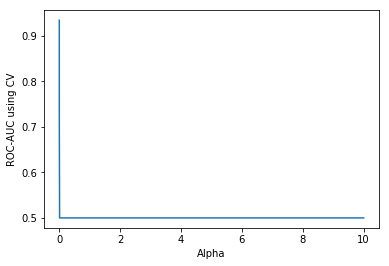

max value of roc_auc : 0.9342691520726032
Optimal value of alpha:  1e-05


In [122]:
plot_metric(alpha,cv_scores_l1)

Again, we see a better ruc_auc value with L2 penalty, but lets check both penalties on test data and decide which one performs better.

###### Check Test Data 

In [193]:
tfidf_SVM_linear=SGDClassifier(loss='hinge', penalty='l1', alpha=0.00001)
tfidf_SVM_linear.fit(tf_idf_train_counts,Y_train_Polarity)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [194]:
test_predict=tfidf_SVM_linear.predict(tf_idf_test_counts)

In [195]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [196]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.8245687545035688


With L1 we get roc_auc of 0.82 while with L2 we get 0.81.

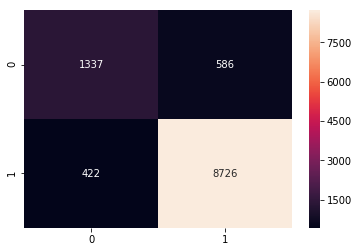

In [197]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [198]:
fpr,tpr,_=roc_curve(actual_test,predicted_test)

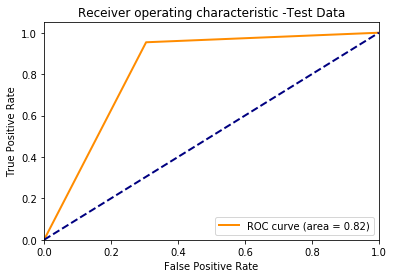

In [199]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

###### AUC after Calibration

In [200]:
## use calibrated cv with isotonic calibration
clf=SGDClassifier(loss='hinge', penalty='l1', alpha=0.00001)
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(tf_idf_train_counts, Y_train_Polarity)
prob_pos_isotonic = clf_isotonic.predict_proba(tf_idf_test_counts)[:, 1]

In [201]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [202]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.9451218035603803


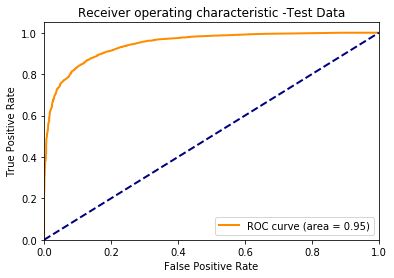

In [203]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

###### Feature Importance for positive and negative words

In [135]:
Coef=tfidf_SVM_linear.coef_

In [136]:
neg_class=sorted(zip(Coef[0],tf_idf_vect.get_feature_names()),reverse=False)[:50]
pos_class=sorted(zip(Coef[0],tf_idf_vect.get_feature_names()),reverse=True)[:50]
print('Most Negative Words')
print(neg_class)
print('------------------------')
print('Most Positive Words')
print(pos_class)

Most Negative Words
[(-189.53535817392503, 'stool'), (-189.10104657434766, 'disappointing'), (-182.9871701864397, 'worst'), (-156.72518608534202, 'colon'), (-125.04585088842131, 'yuck'), (-123.03158621120261, 'disgusting'), (-112.92312426691562, 'didnt'), (-110.5262080381461, 'threw'), (-108.15434124791382, 'died'), (-105.05492303477392, 'constipation'), (-104.94282179181118, 'hopes'), (-104.94184218566004, 'trash'), (-103.48402063552935, 'awful'), (-102.1827998995825, 'terrible'), (-101.34085312058453, 'watermelon'), (-97.33771439941779, 'shame'), (-95.80238398102766, 'substance'), (-95.18356978179217, 'horrible'), (-92.18188992799338, 'bland'), (-90.74433541960468, 'lays'), (-89.44121061835791, 'literally'), (-84.482325899881, 'straining'), (-82.72079139506947, 'fructose'), (-81.93154963947721, 'drug'), (-80.8504895135116, 'positive'), (-80.69436470656986, 'cancelled'), (-80.57522399373435, 'disappointment'), (-79.94363385581184, 'basically'), (-79.41770095140781, 'tasteless'), (-78.

###### Imp Positive Words

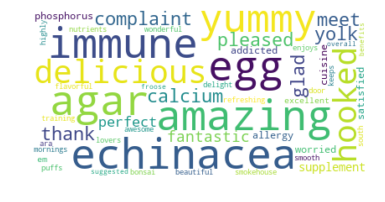

In [137]:
# Create and generate a word cloud image:
pos_weights,pos_words = zip(*pos_class)
text_pos = " ".join(word for word in pos_words)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)

# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Imp Negative Words

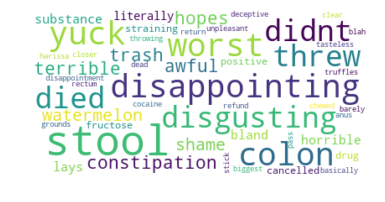

In [138]:
# Create and generate a word cloud image:
neg_weights,neg_words = zip(*neg_class)
text_neg = " ".join(word for word in neg_words)

wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)

# Display the generated image:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [82]:
## Split each text row into words for train data
sent_split_train=[sent.split() for sent in Train_data['CleanedText'].values]
print(sent_split_train[0])

['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'chicken', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'product', 'wont', 'take', 'chances', 'till', 'know', 'going', 'china', 'imports']


In [83]:
## Train Word2Vec Model.Consider words with min frequency 5.

w2vModel=Word2Vec(sent_split_train,min_count=5,size=100,workers=4)

In [84]:
## W2V Train Vocab
w2v_words_train = list(w2vModel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  11222
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


In [85]:
## Find Avg Word Vectors for each sentence. Use for both Train,CV and Test Data

def AvgWord2Vec(sent_split):
    '''
    This function takes the sentences from the text and computes avg word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text
    output:
    avg_sent_vectors: List of avg word vectors of dimension 50
    '''
    avg_sent_vectors=[]
    for sent in sent_split:
        sent_vect=np.zeros(100)
        cnt_word=0
        for word in sent:
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                cnt_word+=1
                sent_vect+=word_vec
        if cnt_word != 0:
            sent_vect/=cnt_word
        avg_sent_vectors.append(sent_vect)
    return(avg_sent_vectors)

In [86]:
avg_vectors_train=AvgWord2Vec(sent_split_train)
print(avg_vectors_train[0])

[ 0.35993384 -0.09698836  0.02837786 -0.05590248  0.0013266  -0.33804127
 -0.06833006  0.05179335  0.12510818  0.2016076  -0.39326936  0.01300546
 -0.06815557  0.16024774 -0.08734485 -0.02451201  0.0749396  -0.04182368
 -0.09365393  0.01336758 -0.41897861 -0.41841898 -0.52672442  0.31379523
  0.30656166  0.42645879  0.12145351  0.08372029 -0.43686646  0.1864321
  0.15288995  0.66802172 -0.49130095 -0.48003849 -0.16260593 -0.43368405
  0.12495297  0.01776043 -0.16457346  0.27463478 -0.03339776 -0.00759711
  0.20974511 -0.41177252 -0.32099102 -0.19292125 -0.60391193 -0.10027361
  0.28446574  0.08478704  0.31953944 -0.15875708  0.02815068 -0.06490146
 -0.09826161  0.41978048  0.06291051  0.14754056 -0.12811283 -0.14979195
  0.31604288  0.2816865  -0.0908871   0.43210121 -0.20479589  0.05000742
 -0.03715665 -0.45233303  0.50523612  0.14579829  0.40176261  0.24143748
  0.00894704 -0.16779187  0.525799   -0.39694452  0.51004711 -0.97490526
  0.46535421 -0.01743858 -0.04184709 -0.28061604 -0.

In [87]:
## Split each text row into words for test data
sent_split_test=[sent.split() for sent in Test_data['CleanedText'].values]
print(sent_split_test[0])

['favorite', 'coffees', 'big', 'dark', 'roasts', 'like', 'french', 'italian', 'full', 'city', 'k', 'cup', 'dark', 'roast', 'big', 'bold', 'flavor', 'lacks', 'balance', 'level', 'smokiness', 'bitterness', 'acid', 'way', 'high', 'result', 'not', 'enjoyable', 'liked', 'dark', 'roasts', 'keurig', 'green', 'mt', 'newman', 'donut', 'shop', 'much', 'one']


In [88]:
avg_vectors_test=AvgWord2Vec(sent_split_test)
print(avg_vectors_test[0])

[-0.24492937 -0.03168857  0.40400938  0.20363918 -0.08838874 -0.19523452
  0.41879486  0.2886486  -0.11899671 -0.34495169  0.09189873 -0.07319816
 -0.10777096 -0.12848686  0.10746649 -0.23336047 -0.17235797  0.30126987
  0.29865956 -0.0479978  -0.23244381  0.16523134 -0.27766796  0.12632136
  0.29319267  0.06375729  0.1415955  -0.05354012  0.17074221  0.58053677
 -0.03204965  0.28884986 -0.30513166 -0.6049445   0.60084555 -0.12813585
  0.07049332  0.1176807   0.12947462  0.78114387 -0.16722763  0.40981746
  0.15616124 -0.18228589 -0.08660094  0.94170268 -0.21199402  0.12541212
 -0.26625308  0.62512205  0.13035827  0.18036487  0.0839372  -0.49674433
 -0.08179125 -0.35124037 -0.3548915  -0.18921506  0.05567324 -0.20936987
 -0.73448761 -0.20787204  0.40930959 -0.21709758 -0.4256563  -0.27818832
  0.61990874 -0.15107691  0.194615   -0.25802545 -0.01209374  0.08004274
  0.22760591 -0.24673675 -0.55199293  0.02537439 -0.29489448  0.05154016
  0.12335274  0.54532391 -0.02946949 -0.88733415 -0

In [146]:
def find_optimal_alpha(data,target,penalty):
    alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10]
    cv_scores=[]
    for a in alpha:
        SVM_linear=SGDClassifier(loss='hinge', penalty=penalty, alpha=a)
        scores = cross_val_score(SVM_linear, data, target, cv=10, scoring='roc_auc')
        cv_scores.append(scores.mean())
    return cv_scores

In [151]:
cv_scores_l2=find_optimal_alpha(avg_vectors_train,Y_train_Polarity,'l2')

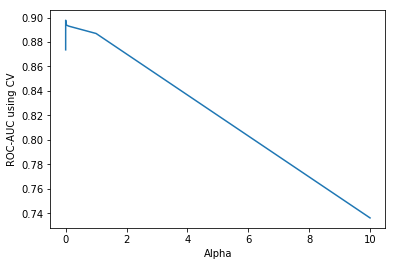

max value of roc_auc : 0.8977665963635653
Optimal value of alpha:  0.001


In [152]:
plot_metric(alpha,cv_scores_l2)

In [153]:
cv_scores_l1=find_optimal_alpha(avg_vectors_train,Y_train_Polarity,'l1')

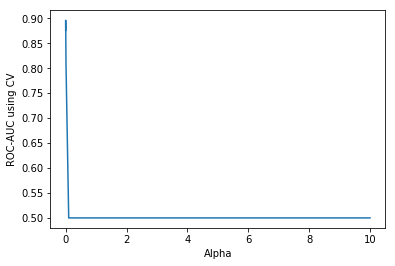

max value of roc_auc : 0.8959911540241248
Optimal value of alpha:  0.0001


In [154]:
plot_metric(alpha,cv_scores_l1)

###### Let's check test data now

In [163]:
SVM_linear=SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
SVM_linear.fit(avg_vectors_train,Y_train_Polarity)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [205]:
test_predict=SVM_linear.predict(avg_vectors_test)

In [172]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [173]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.7189366018016322


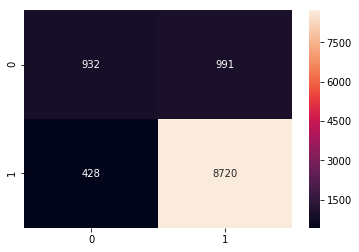

In [174]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [178]:
fpr1,tpr1,_=roc_curve(actual_test,predicted_test)
print(fpr1,tpr1)

[0.         0.51534061 1.        ] [0.         0.95321382 1.        ]


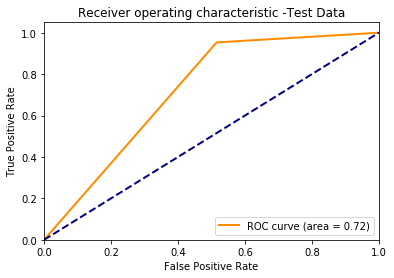

In [179]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

###### AUC after Calibration

In [206]:
## use calibrated cv with isotonic calibration
def calibrated_clf(data,test_data,target,penalty,alpha):
    clf=SGDClassifier(loss='hinge', penalty=penalty, alpha=alpha)
    clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
    clf_isotonic.fit(data, target)
    prob_pos_isotonic = clf_isotonic.predict_proba(test_data)[:, 1]
    return prob_pos_isotonic

In [207]:
prob_pos_isotonic=calibrated_clf(avg_vectors_train,avg_vectors_test,Y_train_Polarity,'l2',0.001)

In [208]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [209]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.8957135460757302


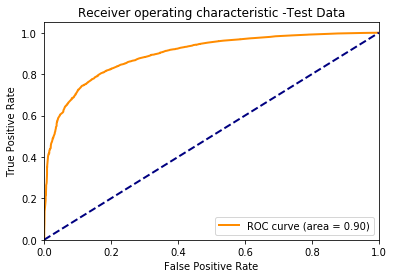

In [210]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

We get better AUC after calibration of model.

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [101]:
# we are converting a dictionary with word as a key, and the idf as a value 
## Code snippet from AAIC notebook

dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [102]:
## Clean '-' from sentences
import re
def clean_wrd(wrd):
    cleanhash=re.compile('-')
    cleanwrd=re.sub(cleanhash,'',wrd)
    return cleanwrd

In [103]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[0:100])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also', 'alternative', 'although', 'always', 'amazing', 'amazon', 'amount', 'another', 'anyone', 'anything', 'aroma', 'around', 'arrived', 'artificial', 'ate', 'available', 'away', 'awesome', 'baby', 'back', 'bad', 'bag', 'bags', 'bar', 'bars', 'beans', 'beef', 'believe', 'best', 'better', 'big', 'bit', 'bitter', 'black', 'blend', 'blue', 'bottle', 'bought', 'box', 'boxes', 'brand', 'brands', 'bread', 'breakfast', 'brown', 'butter', 'buy', 'buying', 'cake', 'calories', 'came', 'candy', 'cannot', 'cans', 'care', 'case', 'cat', 'cat food', 'cats', 'cereal', 'chai', 'cheaper', 'cheese', 'chew', 'chicken', 'chip', 'chips', 'chocolate', 'cinnamon', 'clean', 'cocoa', 'coconut', 'coffee', 'cold', 'come', 'comes', 'company', 'compared', 'container', 'cook', 'cookie', 'cookies', 'cooking', 'corn', 'cost', 'could', 'could not', 'couple', 'course', 'crackers', 'cream', '

In [104]:
def AvgWord2Vectfidf(sent_split):
    '''
    This function takes the sentences from the text and tf idf counts and computes tf idf weighted word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text and tf idf counts
    output:
    tf_idf_sent_vectors: List of tf idf weighted word vectors of dimension 50
    '''
    tf_idf_sent_vectors=[]
    for sent in sent_split:
        sent_vec=np.zeros(100)
        weight_sum=0
        for word in sent:
            word=clean_wrd(word)
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                try:
                    #tf_idf = tf_idf_counts[row, features.index(word)]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (word_vec * tf_idf)
                    weight_sum += tf_idf
                except:
                    continue
        if weight_sum != 0:
            sent_vec/=weight_sum
        tf_idf_sent_vectors.append(sent_vec)
    return(tf_idf_sent_vectors)

In [105]:
tf_idf_vectors_train=AvgWord2Vectfidf(sent_split_train)
print(len(tf_idf_vectors_train))

35000


In [106]:
tf_idf_vectors_test=AvgWord2Vectfidf(sent_split_test)
print(len(tf_idf_vectors_test))

11071


In [217]:
cv_scores_l2=find_optimal_alpha(tf_idf_vectors_train,Y_train_Polarity,'l2')

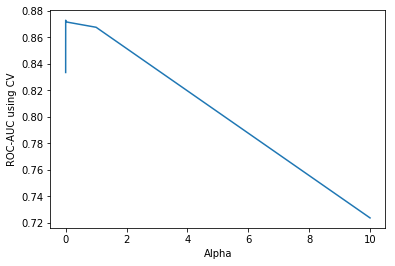

max value of roc_auc : 0.8729901942057546
Optimal value of alpha:  0.001


In [218]:
plot_metric(alpha,cv_scores_l2)

In [219]:
cv_scores_l1=find_optimal_alpha(tf_idf_vectors_train,Y_train_Polarity,'l1')

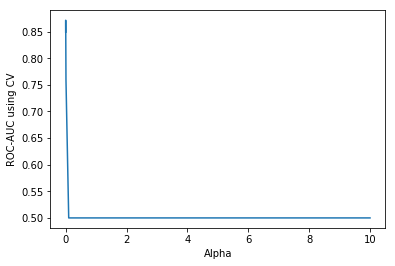

max value of roc_auc : 0.8714572027625781
Optimal value of alpha:  0.001


In [220]:
plot_metric(alpha,cv_scores_l1)

In [221]:
SVM_linear=SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
SVM_linear.fit(tf_idf_vectors_train,Y_train_Polarity)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [223]:
test_predict=SVM_linear.predict(tf_idf_vectors_test)

In [224]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [225]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.6691590488280659


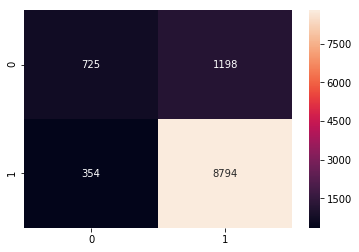

In [226]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [227]:
fpr1,tpr1,_=roc_curve(actual_test,predicted_test)
print(fpr1,tpr1)

[0.         0.62298492 1.        ] [0.         0.96130302 1.        ]


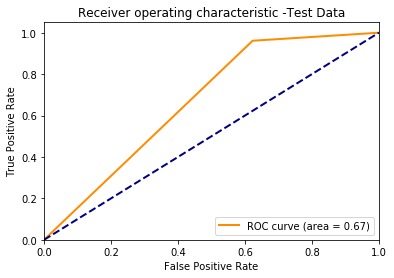

In [228]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

###### AUC after Calibrating Model

In [229]:
prob_pos_isotonic=calibrated_clf(tf_idf_vectors_train,tf_idf_vectors_test,Y_train_Polarity,'l2',0.001)

In [230]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [231]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.8651762795479023


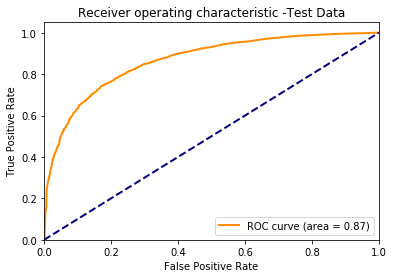

In [232]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [35]:
from sklearn.decomposition import TruncatedSVD

In [36]:
## FOR RBF Kernel we have to reduce the dimesnionality and hence we create our featurizations again with less features.
## We use min_df=10and max_features =400
## We also try Bi-grams this time

# Create BOW with Train data
count_vect=CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
vocab=count_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
Train_counts=count_vect.transform(Train_data['CleanedText'].values)
Train_counts.get_shape()

(35000, 500)

In [37]:
# Fit our BOW vectorizer on test data
Test_counts=count_vect.transform(Test_data['CleanedText'].values)
Test_counts.get_shape()

(11071, 500)

In [39]:
C_val=[0.00001,0.0001,0.001,0.01,0.1,1,10]
gamma=[0.1, 1, 10, 100]

In [38]:
def find_optimal_C(data,target,C_val,gamma):
    cv_scores=[]
    gamma_value=[]
    C_value=[]
    for a in C_val:
        for g in gamma:            
            SVM_rbf=SVC(C=a,gamma=g)
            scores = cross_val_score(SVM_rbf, data, target, cv=3, scoring='roc_auc')
            C_value.append(a)
            gamma_value.append(g)
            cv_scores.append(scores.mean())
    return C_value,gamma_value,cv_scores

In [40]:
C,G,cv_score_rbf=find_optimal_C(Train_counts,Y_train_Polarity,C_val,gamma)

In [41]:
def plot_metric_2(C_val,gamma,optimal_auc):
    val_dict={'C':C_val,'gamma':gamma,'AUC':optimal_auc}
    val_df=pd.DataFrame(val_dict)
    val_df_pivot=val_df.pivot_table(index='C',columns='gamma',values='AUC')
    sns.heatmap(val_df_pivot,annot=True)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.title('Finding Optimal Tree Parameters using AUC')
    plt.show()

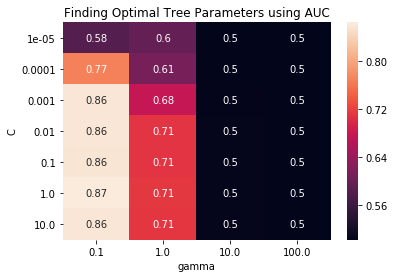

In [43]:
plot_metric_2(C,G,cv_score_rbf)

###### Check on Test Data

In [52]:
SVM_rbf=SVC(C=10,gamma=0.1)
SVM_rbf.fit(Train_counts,Y_train_Polarity)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
test_predict=SVM_rbf.predict(Test_counts)

In [54]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [55]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.630554126843692


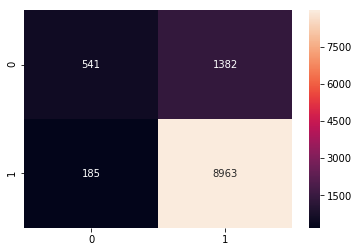

In [56]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [57]:
fpr1,tpr1,_=roc_curve(actual_test,predicted_test)
print(fpr1,tpr1)

[0.         0.71866875 1.        ] [0.       0.979777 1.      ]


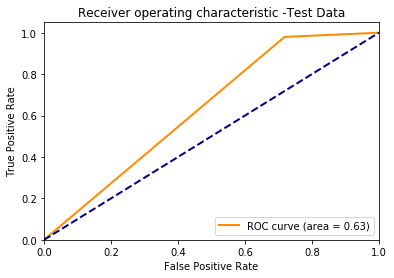

In [58]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

###### AUC using Calibrated Model

In [59]:
## use calibrated cv with isotonic calibration
def calibrated_clf(data,test_data,target,c,g):
    clf=SVC(C=c,gamma=g)
    clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
    clf_isotonic.fit(data, target)
    prob_pos_isotonic = clf_isotonic.predict_proba(test_data)[:, 1]
    return prob_pos_isotonic

In [60]:
prob_pos_isotonic=calibrated_clf(Train_counts,Test_counts,Y_train_Polarity,10,0.1)

In [61]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [62]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.8682676406312921


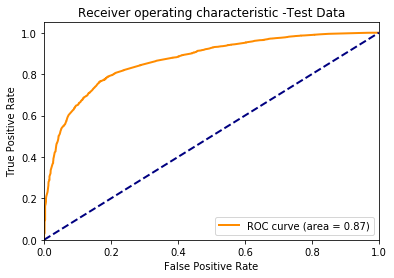

In [63]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [64]:
## Create a tf-idf vectorizer-unigram

## For Train data

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vocab=tf_idf_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
tf_idf_train_counts=tf_idf_vect.transform(Train_data['CleanedText'].values)
tf_idf_train_counts.get_shape()

(35000, 500)

In [65]:
## For Test data
tf_idf_test_counts=tf_idf_vect.transform(Test_data['CleanedText'].values)
tf_idf_test_counts.get_shape()

(11071, 500)

In [66]:
C,G,cv_score_rbf=find_optimal_C(tf_idf_train_counts,Y_train_Polarity,C_val,gamma)

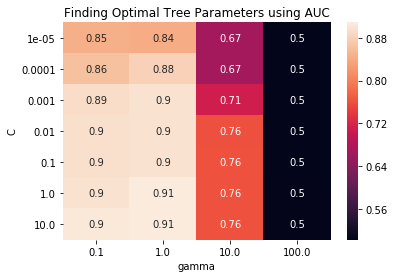

In [67]:
plot_metric_2(C,G,cv_score_rbf)

In [68]:
SVM_rbf=SVC(C=1,gamma=1)
SVM_rbf.fit(tf_idf_train_counts,Y_train_Polarity)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [69]:
test_predict=SVM_rbf.predict(tf_idf_test_counts)

In [70]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [71]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.733950042304272


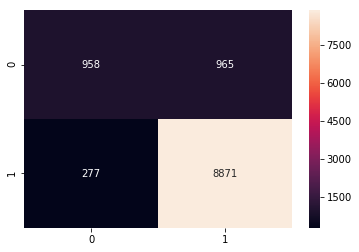

In [72]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [73]:
fpr1,tpr1,_=roc_curve(actual_test,predicted_test)
print(fpr1,tpr1)

[0.         0.50182007 1.        ] [0.         0.96972016 1.        ]


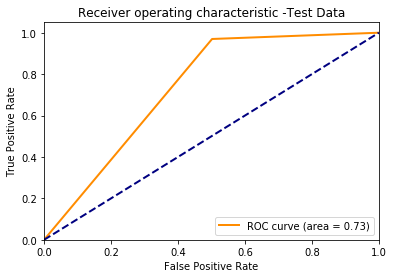

In [74]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Test Data')
plt.legend(loc="lower right")
plt.show()

In [76]:
prob_pos_isotonic=calibrated_clf(tf_idf_train_counts,tf_idf_test_counts,Y_train_Polarity,1,1)

In [77]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [78]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.9095944292515907


In [79]:
## ROC- AUC Plot
def roc_auc_plot(fpr,tpr,test_roc):
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic -Test Data')
    plt.legend(loc="lower right")
    plt.show()

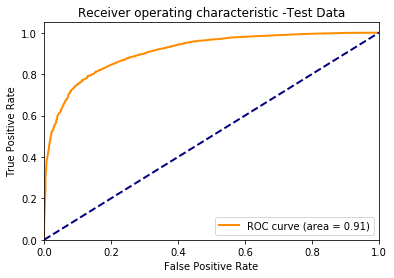

In [80]:
roc_auc_plot(fpr,tpr,test_roc)

After Calibrating the model , we get a good auc !!

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [89]:
## Find optimal C for rbf svm

C,G,cv_score_rbf=find_optimal_C(avg_vectors_train,Y_train_Polarity,C_val,gamma)

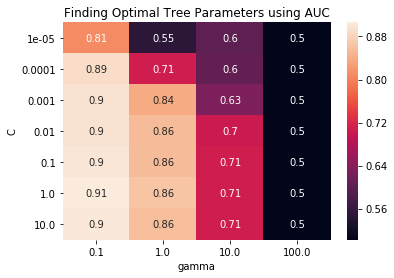

In [90]:
plot_metric_2(C,G,cv_score_rbf)

In [91]:
SVM_rbf=SVC(C=10,gamma=0.1)
SVM_rbf.fit(avg_vectors_train,Y_train_Polarity)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
test_predict=SVM_rbf.predict(avg_vectors_test)

In [93]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [94]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.7442505242841982


In [95]:
fpr1,tpr1,_=roc_curve(actual_test,predicted_test)
print(fpr1,tpr1)

[0.         0.46853874 1.        ] [0.         0.95703979 1.        ]


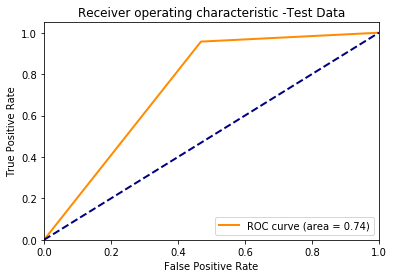

In [96]:
roc_auc_plot(fpr1,tpr1,test_roc)

###### AUC after model calibration

In [97]:
prob_pos_isotonic=calibrated_clf(avg_vectors_train,avg_vectors_test,Y_train_Polarity,10,0.1)

In [98]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [99]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.9053456410228424


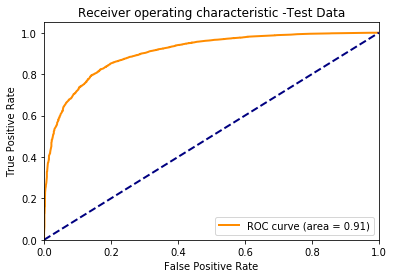

In [100]:
roc_auc_plot(fpr,tpr,test_roc)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [107]:
## Find optimal C for rbf svm

C,G,cv_score_rbf=find_optimal_C(tf_idf_vectors_train,Y_train_Polarity,C_val,gamma)

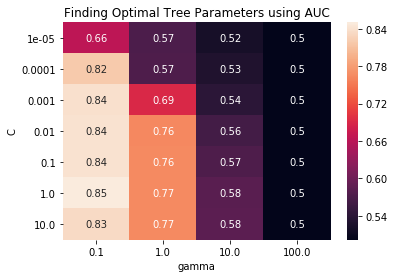

In [108]:
plot_metric_2(C,G,cv_score_rbf)

###### Check on Test Data using optimal parameters

In [109]:
SVM_rbf=SVC(C=1,gamma=0.1)
SVM_rbf.fit(tf_idf_vectors_train,Y_train_Polarity)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
test_predict=SVM_rbf.predict(tf_idf_vectors_test)

In [111]:
actual_test=Test_data['Score']
predicted_test=test_predict

In [112]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.6510730914588574


In [113]:
fpr1,tpr1,_=roc_curve(actual_test,predicted_test)
print(fpr1,tpr1)

[0.         0.67030681 1.        ] [0.       0.972453 1.      ]


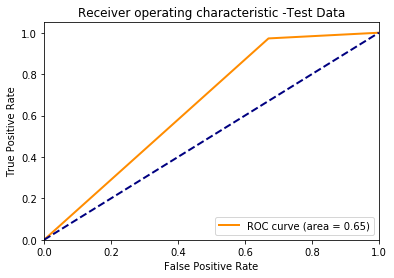

In [114]:
roc_auc_plot(fpr1,tpr1,test_roc)

###### AUC using Calibrated Model

In [116]:
prob_pos_isotonic=calibrated_clf(avg_vectors_train,avg_vectors_test,Y_train_Polarity,1,0.1)

In [117]:
fpr,tpr,_=roc_curve(actual_test,prob_pos_isotonic)

In [118]:
## Lets check ROC-AUC for the model
test_roc=roc_auc_score(actual_test,prob_pos_isotonic)
print('Test AUC:',test_roc)

Test AUC: 0.9024753797322859


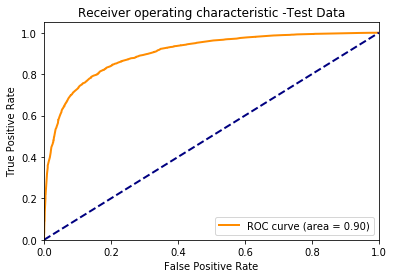

In [119]:
roc_auc_plot(fpr,tpr,test_roc)

# [6] Conclusions

In [109]:
#Compare all your models using Prettytable library

#!pip install PTable

  Running setup.py bdist_wheel for PTable: started
  Running setup.py bdist_wheel for PTable: finished with status 'done'
  Stored in directory: C:\Users\Gaurav\AppData\Local\pip\Cache\wheels\22\cc\2e\55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [121]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Featurisation", "Model Type","C/Alpha","Gamma", "Calibrated AUC"]
x.add_row(["BOW", "Linear SVM",0.001,'-',0.94])
x.add_row(["TFIDF", "Linear SVM",0.00001,'-',0.95])
x.add_row(["AVG W2Vec", "Linear SVM",0.001,'-',0.90])
x.add_row(["TFIDF W2Vec", "Linear SVM",0.001,'-',0.87])
x.add_row(["BOW", "RBF SVM",10,0.1,0.87])
x.add_row(["TFIDF", "RBF SVM",1,1,0.91])
x.add_row(["AVG W2vec", "RBF SVM",10,0.1,0.91])
x.add_row(["TFIDF W2Vec", "RBF SVM",1,0.1,0.90])

print(x)

+---------------+------------+---------+-------+----------------+
| Featurisation | Model Type | C/Alpha | Gamma | Calibrated AUC |
+---------------+------------+---------+-------+----------------+
|      BOW      | Linear SVM |  0.001  |   -   |      0.94      |
|     TFIDF     | Linear SVM |  1e-05  |   -   |      0.95      |
|   AVG W2Vec   | Linear SVM |  0.001  |   -   |      0.9       |
|  TFIDF W2Vec  | Linear SVM |  0.001  |   -   |      0.87      |
|      BOW      |  RBF SVM   |    10   |  0.1  |      0.87      |
|     TFIDF     |  RBF SVM   |    1    |   1   |      0.91      |
|   AVG W2vec   |  RBF SVM   |    10   |  0.1  |      0.91      |
|  TFIDF W2Vec  |  RBF SVM   |    1    |  0.1  |      0.9       |
+---------------+------------+---------+-------+----------------+


* Thus we see that TF-IDF with Linear SVM performs best on our Test Data